# Analysis of the New Post-Purchase Survey Data
### Explore the Data
Now that we have our data in a form that we can use it (ETL), we need to do some exploration of the data to see what it looks like.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import vonmises
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline
import math

In [2]:
weekday_df = pd.read_csv('hourly_count_weekday.csv', index_col=False)

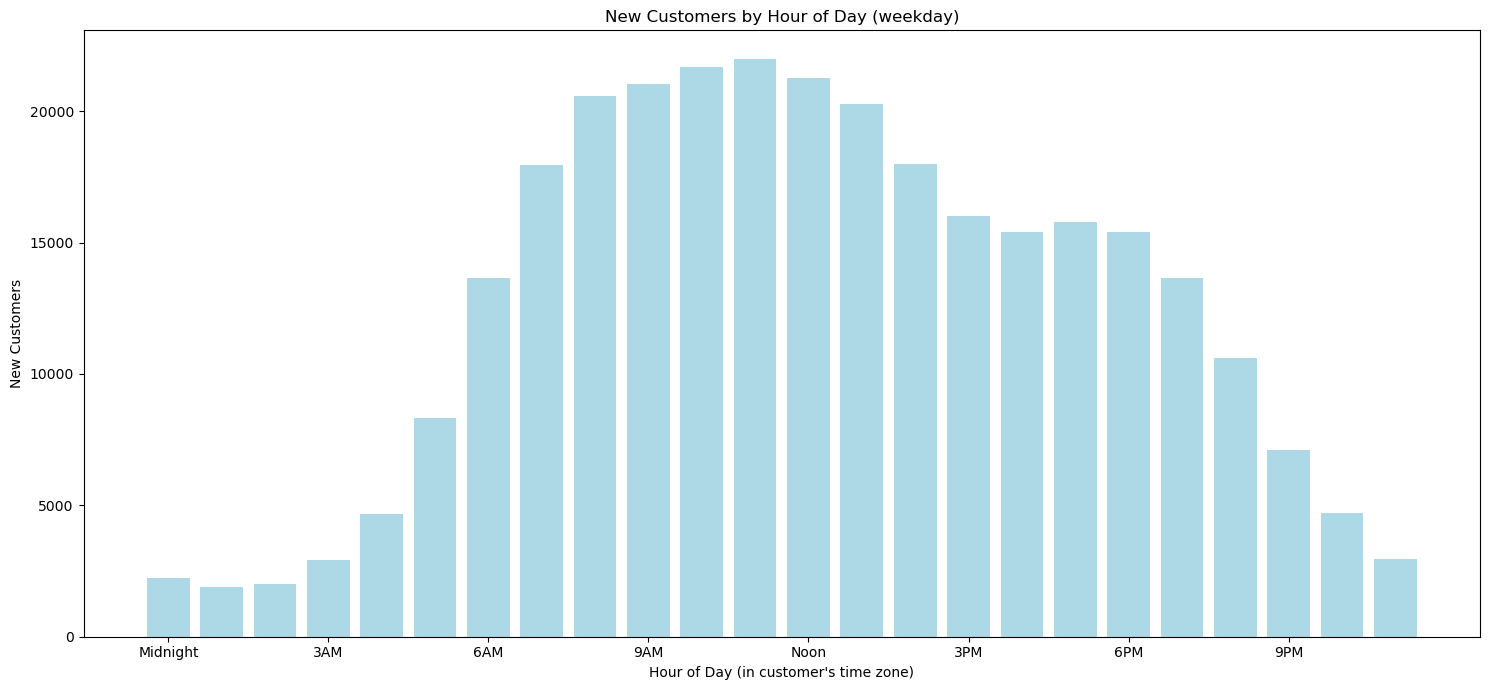

In [3]:
barcolor="lightblue"
ax = plt.figure(figsize=(15,7))
plt.axes().set_xticks(range(0, 24, 3),
    labels=['Midnight', '3AM', '6AM', '9AM', 'Noon', '3PM', '6PM', '9PM'])
plt.title('New Customers by Hour of Day (weekday)')
plt.xlabel("Hour of Day (in customer's time zone)")
plt.ylabel('New Customers')
plt.bar(weekday_df['HourOfDay'], weekday_df['Count'], color=barcolor, label='data')
plt.tight_layout()

### What do we see?
This is interesting. To my eye, there appears to be two overlapping gaussian (normal) distributions, centered around 11:00 (11AM) and 18:00 (6PM).  This data has already been normalized to the time zone of the customer so these differences do not indicate just time zone shifts.

### Why is this important?
This might indicate that there are two different types of customers that buy our products and they might have different needs that can be targeted.  There certainly is enough data collected to verify if this is a good model, so let's evaluate it.

### How do we begin?
First off, the data is collected around the clock and so a simple fitting to a gaussian distribution is not best since the tails of the distributions not only overlap but wrap into the previous and next day.  For this we need to model a circular normal distribution.  The von Mises distribution is a good approximation and will be used to handle this case.

Below, we need to convert the hour of the day range (0 to 23) to the angle (in radians) of a full circle for one day (range 0 to 2$\pi$)

In [4]:
two_pi = 2 * np.pi
weekday_df['Angle'] = ((two_pi * weekday_df['HourOfDay']) / 24)
weekday_df.head()

,HourOfDay,Count,Angle
0,0,2216,0.000000
1,1,1875,0.261799
2,2,1997,0.523599
3,3,2907,0.785398
4,4,4680,1.047198


### Create helper functions
I am creating a function which returns the sum of two von Mises distributions given the input of the six parameters of the distributions and the count of new customers at each hour; as well as a simple function for a single von Mises distribution.

In [5]:
def two_von_mises(x, amp1, cen1, kappa1, amp2, cen2, kappa2):
    return (amp1 * vonmises.pdf(x-cen1, kappa1)) + \
           (amp2 * vonmises.pdf(x-cen2, kappa2))

def one_von_mises(x, amp, cen, kappa):
    return amp * vonmises.pdf(x-cen, kappa)

In [6]:
def fit_it(hourly_df):
    popt, pcov = curve_fit(
        two_von_mises, 
        hourly_df['Angle'], 
        hourly_df['Count']
    )
    return popt, pcov

In [7]:
def hour_minute_string(angle_radians):
    while angle_radians < 0:
        angle_radians += two_pi
    while angle_radians > two_pi:
        angle_radians -= two_pi
    hours_float    = angle_radians * 24 / two_pi
    hour_of_day    = int(math.floor(hours_float))
    minute_of_hour = round((hours_float % 1) * 60)
    if minute_of_hour == 60:
        minute_of_hour = 0
        hour_of_day += 1
        if hour_of_day >= 23:
            hour_of_day = 0
    if   minute_of_hour == 0 and hour_of_day == 0:
        return 'Midnight'
    elif minute_of_hour == 0 and hour_of_day == 12:
        return 'Noon'
    if hour_of_day >= 12:
        am_pm = 'PM'
        hour_of_day -= 12
    else:
        am_pm = 'AM'
    return f'{hour_of_day:02d}:{minute_of_hour:02d}{am_pm}'

In [8]:
def pearsons_r2(a, b):  
    return (
        np.mean((a - np.mean(a)) * (b - np.mean(b)))
        / np.std(a) / np.std(b)) ** 2

def coeff_determination_R2(a, b):
    ss_res = np.sum((a - b) ** 2)
    ss_tot = np.sum((a - np.mean(a)) ** 2)
    return 1 - ss_res / ss_tot

In [9]:
def analyze_it(hourly_df, popt):
    a = hourly_df['Count']
    b = two_von_mises(hourly_df['Angle'], *popt)
    
    r2 = pearsons_r2(a, b)
    R2 = coeff_determination_R2(a, b)

    results = ['von Mises Parameters\n']
    
    off_loc = hour_minute_string(popt[4])
    bus_loc = hour_minute_string(popt[1])

    params = [
        ['Amplitude (bus. hours):', f'{popt[0]:10.3f}' ],
        ['Location  (bus. hours):', f'{bus_loc:>10}'   ],
        ['Kappa     (bus. hours):', f'{popt[2]:10.3f}' ],
        ['',                        ''                 ],
        ['Amplitude (off hours): ', f'{popt[3]:10.3f}' ],
        ['Location  (off hours): ', f'{off_loc:>10}'   ],
        ['Kappa     (off hours): ', f'{popt[5]:10.3f}' ]
    ]

    for _, param in enumerate(params):
        results.append(f'{param[0]}{param[1]}')

    results.append(f'\nPearson\'s r\u00b2:              {r2:.4f}')
    results.append(f'Coef of Determ R\u00b2:         {R2:.4f}')

    results = '\n'.join(results)
    return results

In [10]:
def plot_it(hourly_df, popt, results, title, barcolor, linewidth = 3):
    ax = plt.figure(figsize=(15,7))
    plt.axes().set_xticks(range(0, 24, 3),
        labels=['Midnight', '3AM', '6AM', '9AM', 'Noon', '3PM', '6PM', '9PM'])
    plt.bar(hourly_df['HourOfDay'], hourly_df['Count'], color=barcolor, label='data')

    X_ = np.linspace(hourly_df['HourOfDay'].min(), hourly_df['HourOfDay'].max(), 500)

    X_Y_Spline = make_interp_spline(hourly_df['HourOfDay'], two_von_mises(hourly_df['Angle'], *popt))
    Y_ = X_Y_Spline(X_)
    plt.plot(X_, Y_, color='black', label='combined fit', linewidth=linewidth)

    X_Y_Spline = make_interp_spline(hourly_df['HourOfDay'], one_von_mises(hourly_df['Angle'], *popt[0:3]))
    Y_ = X_Y_Spline(X_)
    plt.plot(X_, Y_, color='green', label='business hours fit', linewidth=linewidth)

    X_Y_Spline = make_interp_spline(hourly_df['HourOfDay'], one_von_mises(hourly_df['Angle'], *popt[3:6]))
    Y_ = X_Y_Spline(X_)
    plt.plot(X_, Y_, color='red', label='off hours fit', linewidth=linewidth)

    plt.title(title)
    plt.xlabel("Hour of Day (in customer's time zone)")
    plt.ylabel('New Customers')
    plt.legend()

    props = dict(boxstyle='round', facecolor='Cornsilk', alpha=0.5)

    ax.text(0.062, 0.93, results, fontfamily='monospace', fontsize=10, verticalalignment='top', bbox=props)

    plt.tight_layout() 

In [11]:
def plot_it2(hourly_df, popt, results, title, barcolor, linewidth = 3):
    f = plt.figure()
    ax  = f.add_axes([0.30, 0.2, 1.25, 1.25], polar=True) # Left, Bottom, Width, Height
 
    # Set Orientation
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xlim(-np.pi/1.000001, np.pi/1.000001)  # workaround for a weird issue
    ax.set_xticks([-np.pi/1.000001 + i/8 * 2*np.pi/1.000001 for i in range(8)])

    width = .225    
    bars = ax.bar(hourly_df['Angle'], hourly_df['Count'], color=barcolor, label='data', width=width)

    X_ = np.linspace(0, 2 * np.pi, 500)

    X_Y_Spline = make_interp_spline(hourly_df['Angle'], two_von_mises(hourly_df['Angle'], *popt))
    Y_ = X_Y_Spline(X_)
    ax.plot(X_, Y_, color='black', label='combined fit', linewidth=linewidth, alpha=0.3)

    X_Y_Spline = make_interp_spline(hourly_df['Angle'], one_von_mises(hourly_df['Angle'], *popt[0:3]))
    Y_ = X_Y_Spline(X_)
    ax.plot(X_, Y_, color='green', label='business hours fit', linewidth=linewidth, alpha=0.3)

    X_Y_Spline = make_interp_spline(hourly_df['Angle'], one_von_mises(hourly_df['Angle'], *popt[3:6]))
    Y_ = X_Y_Spline(X_)
    ax.plot(X_, Y_, color='red', label='off hours fit', linewidth=linewidth, alpha=0.3)

    ax.set_xticklabels(['Noon', '3PM', '6PM', '9PM', 'Midnight', '3AM', '6AM', '9AM'])
    plt.title(title)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height * 0.8])

    # Put a legend to the right of the current axis
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
 
    props = dict(boxstyle='round', facecolor='Cornsilk', alpha=0.5)

    plt.text(1.225, 0.25, results, fontfamily='monospace', fontsize=8, transform=plt.gcf().transFigure, bbox=props)

    plt.show()

## Fitting the Data
I am using the Python module SciPy to fit the best model for overlapped distributions.  This will return the best estimates for the six parameters to the overlapped von Mises distributions.

In [12]:
popt, pcov = fit_it(weekday_df)

### How good was it?
Comparing the forecasted hourly counts to the actual forecasted counts results in an R&#x00B2; value of 0.9744 (where a value close to 1 indicated a very good forecast)!  This strongly indicates that there are two different groups of new customers.

In [13]:
results = analyze_it(weekday_df, popt)
print(results)

von Mises Parameters

Amplitude (bus. hours): 53826.493
Location  (bus. hours):   09:51AM
Kappa     (bus. hours):     1.429

Amplitude (off hours):  25525.944
Location  (off hours):    05:22PM
Kappa     (off hours):      1.967

Pearson's r²:              0.9767
Coef of Determ R²:         0.9753


### Let's plot our results...

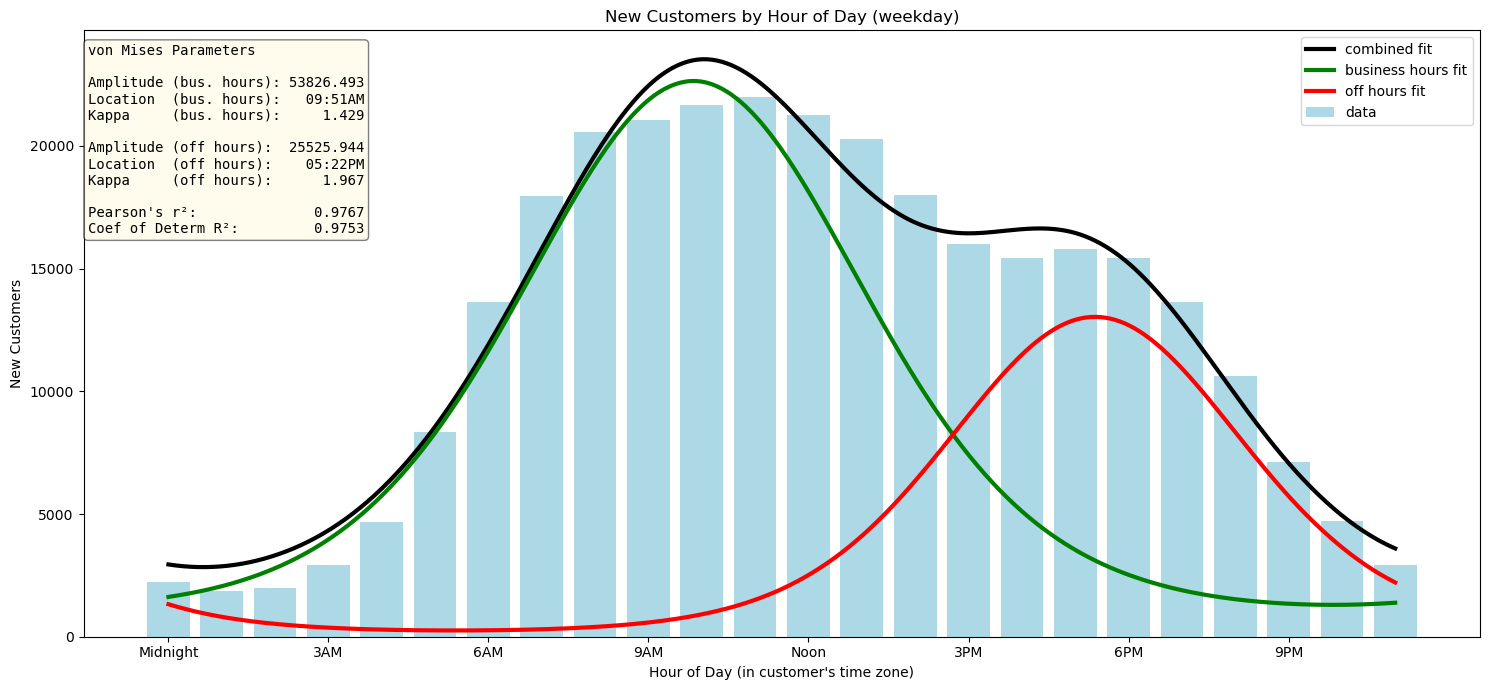

In [14]:
plot_it(weekday_df, popt, results, 'New Customers by Hour of Day (weekday)', barcolor)

In [15]:
ax.figure.savefig("queries_weekday.png")

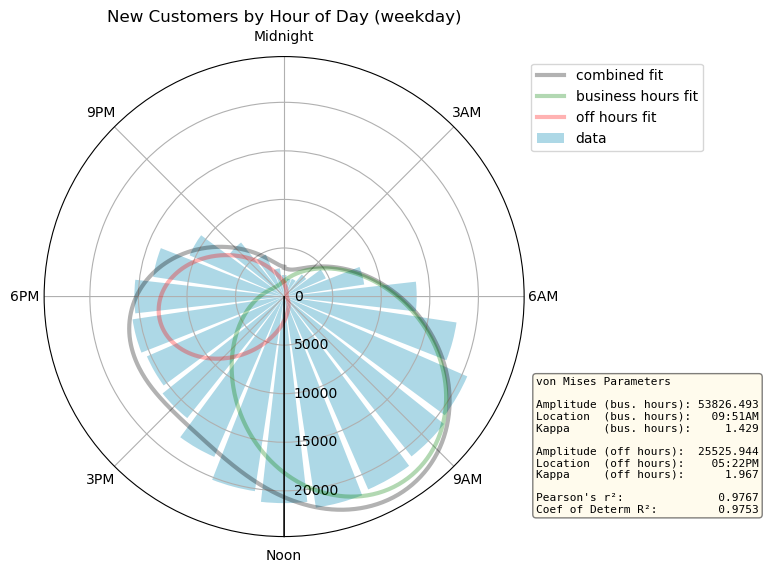

In [16]:
plot_it2(weekday_df, popt, results, 'New Customers by Hour of Day (weekday)', barcolor)

In [17]:
ax.figure.savefig("queries_weekday_polar.png")

## What does this look like on weekends..
The above graph shows the distribution on weekdays (Monday-Friday).  Is there a similiar distribution on weekends?

In [18]:
weekend_df = pd.read_csv('hourly_count_weekend.csv', index_col=False)

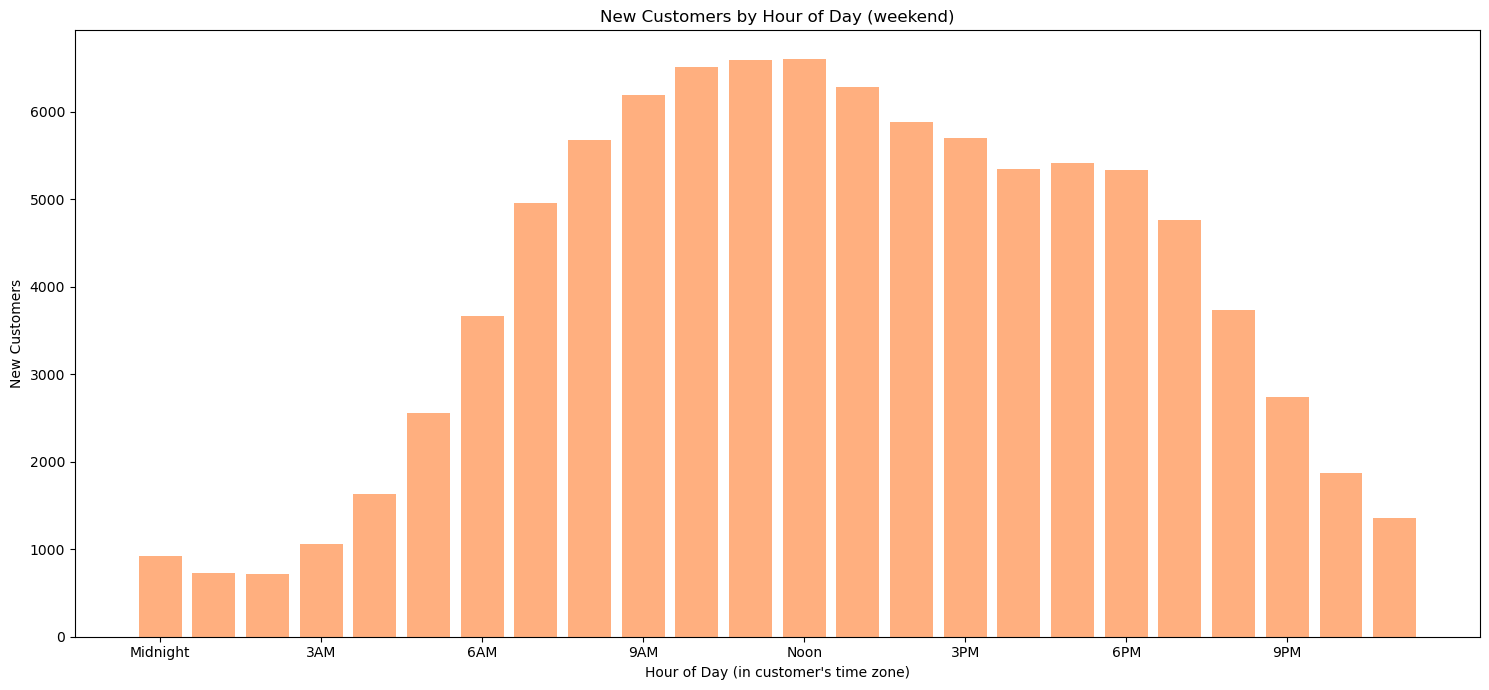

In [19]:
barcolor="#ffaf7f"
ax = plt.figure(figsize=(15,7))
plt.axes().set_xticks(range(0, 24, 3),
    labels=['Midnight', '3AM', '6AM', '9AM', 'Noon', '3PM', '6PM', '9PM'])
plt.title('New Customers by Hour of Day (weekend)')
plt.xlabel("Hour of Day (in customer's time zone)")
plt.ylabel('New Customers')
plt.bar(weekend_df['HourOfDay'], weekend_df['Count'], color=barcolor, label='data')
plt.tight_layout()

### So...
It appears that weekends have a similar distribution.  Let's see how strong the relationship is...

In [20]:
weekend_df['Angle'] = ((two_pi * weekend_df['HourOfDay']) / 24)
weekend_df.head()

,HourOfDay,Count,Angle
0,0,920,0.000000
1,1,725,0.261799
2,2,722,0.523599
3,3,1055,0.785398
4,4,1626,1.047198


In [21]:
popt, pcov = fit_it(weekend_df)

results = analyze_it(weekend_df, popt)
print(results)

von Mises Parameters

Amplitude (bus. hours): 16277.229
Location  (bus. hours):   10:06AM
Kappa     (bus. hours):     1.319

Amplitude (off hours):   9060.863
Location  (off hours):    05:30PM
Kappa     (off hours):      1.837

Pearson's r²:              0.9875
Coef of Determ R²:         0.9868


### Let's plot our results...

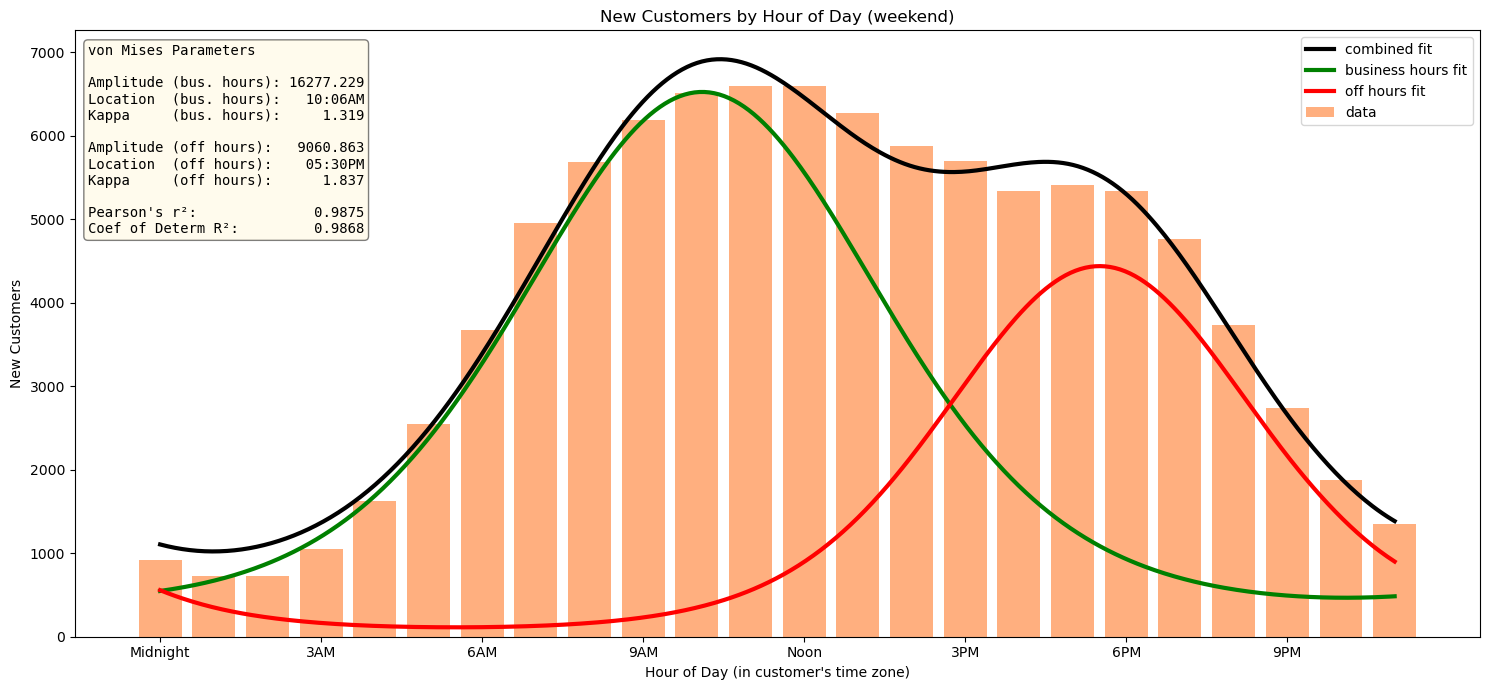

In [22]:
plot_it(weekend_df, popt, results, 'New Customers by Hour of Day (weekend)', barcolor)

In [23]:
ax.figure.savefig("queries_weekend.png")

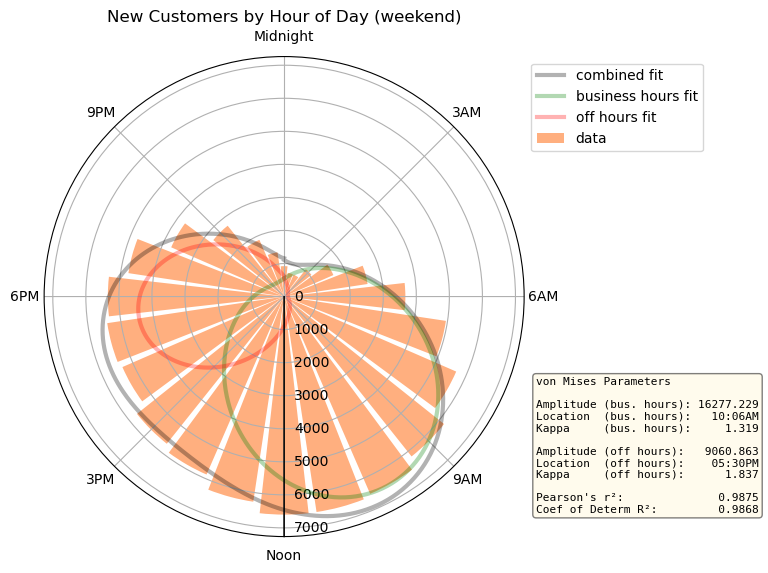

In [24]:
plot_it2(weekend_df, popt, results, 'New Customers by Hour of Day (weekend)', barcolor)

In [25]:
ax.figure.savefig("queries_weekend_polar.png")

## Conclusion
With such a high R&#x00B2; value, overlapping von Mises distributions are a very good model for the data that we observed.  The next step is to determine whether the two groups have real differences or are just clusters around the two times of the day where most new customers make their initial purchases.
To do this we need to look at the other data that we collected on the PPS survey to determine if there are real differences between these two groups.  For an example, if we found out that the second group was more likely to buy website building services, then we might be able to target them by hour of the day (within their own timezones).